# Phase 7: Results Visualization

This notebook reads prediction documents produced by `realtime_predictor.py` from MongoDB, performs analysis and visualizations, demonstrates a simple alert rule, and exports a snapshot for reporting.

Notes:
- If you run this notebook inside the project `jupyter` Docker container, the MongoDB URI is `mongodb://mongo:27017`.
- If running on the host and Mongo is exposed, use `mongodb://localhost:27017`.

The cells below are ordered so you can run them top-to-bottom to load data, inspect it, visualize distributions and time-series, create a simple alert, compute evaluation metrics when labels exist, and finally export artifacts.

## Install / Import dependencies
This cell ensures required Python libraries are available in the notebook kernel. It will install missing packages into the running environment (useful when running in a fresh container).

In [1]:
# Install commonly needed libs for visualization and Mongo access (safe no-op if already installed)
import importlib, subprocess, sys
def ensure(pkg):
    if importlib.util.find_spec(pkg) is None:
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', pkg])

# Packages used in this notebook
for p in ('pandas','pymongo','plotly','kaleido','scikit-learn'):
    try:
        ensure(p)
    except Exception as e:
        print('Could not ensure', p, ':', e)

print('Dependency check complete')

Dependency check complete


## Connect to MongoDB and load predictions
This cell connects to MongoDB and loads the most recent records into a pandas DataFrame. We convert `processing_time` to datetime for time-based analysis.

In [2]:
import os
from pymongo import MongoClient
import pandas as pd

def get_mongo_uri():
    # inside Docker container, /.dockerenv exists
    if os.path.exists('/.dockerenv'):
        return 'mongodb://mongo:27017'
    return 'mongodb://localhost:27017'

MONGO_URI = get_mongo_uri()
print('Using Mongo:', MONGO_URI)
client = MongoClient(MONGO_URI)
db = client.get_database('iot_malware')
col = db.get_collection('predictions')

LIMIT = 20000  # change as needed
# Sort by the most recent timestamp field available to avoid reading huge collections
# The predictor writes a 'timestamp' field; older versions used 'processing_time' or 'original_ts'.
sort_field = None
for f in ('processing_time', 'timestamp', 'original_ts'):
    if col.count_documents({f: {'$exists': True}}) > 0:
        sort_field = f
        break
if sort_field is None:
    cursor = col.find({}, limit=LIMIT)
else:
    cursor = col.find({}, sort=[(sort_field, -1)], limit=LIMIT)
df = pd.DataFrame(list(cursor))
print('Loaded records:', len(df))

# Normalize a processing_time column for downstream cells
if 'processing_time' in df.columns:
    df['processing_time'] = pd.to_datetime(df['processing_time'])
elif 'original_ts' in df.columns:
    df['processing_time'] = pd.to_datetime(df['original_ts'], unit='s')
elif 'timestamp' in df.columns:
    df['processing_time'] = pd.to_datetime(df['timestamp'])

# Convert probability column (if present) from lists to Python lists (safety)
if 'probability' in df.columns:
    df['probability'] = df['probability'].apply(lambda x: list(x) if hasattr(x, '__iter__') and not isinstance(x, str) else x)

# Show a few rows
df.head()

Using Mongo: mongodb://mongo:27017
Loaded records: 20000


,_id,timestamp,id_orig_h,id_orig_p,id_resp_h,id_resp_p,proto,prediction,probability,predicted_label,processing_time
0,6937675ef8dfa447ab388026,2018-05-21 07:04:46,192.168.2.5,36648.0,200.168.87.203,59353.0,tcp,0.0,"[0.9982077110564788, 0.0017922889435212687]",Benign,2018-05-21 07:04:46
1,6937675ef8dfa447ab388025,2018-05-21 07:04:42,192.168.2.5,36647.0,200.168.87.203,59353.0,tcp,0.0,"[0.9982077110564788, 0.0017922889435212687]",Benign,2018-05-21 07:04:42
2,6937675ef8dfa447ab388024,2018-05-21 07:04:35,192.168.2.5,36647.0,200.168.87.203,59353.0,tcp,0.0,"[0.9982077110564788, 0.0017922889435212687]",Benign,2018-05-21 07:04:35
3,6937675ef8dfa447ab388023,2018-05-21 07:04:31,192.168.2.5,36646.0,200.168.87.203,59353.0,tcp,0.0,"[0.9982077110564788, 0.0017922889435212687]",Benign,2018-05-21 07:04:31
4,6937675ef8dfa447ab388022,2018-05-21 07:04:24,192.168.2.5,36646.0,200.168.87.203,59353.0,tcp,0.0,"[0.9982077110564788, 0.0017922889435212687]",Benign,2018-05-21 07:04:24


## Attack type distribution
Plot distribution of attack types (`detailed-label`) and color by predicted label so we can see which attacks are flagged as malicious.

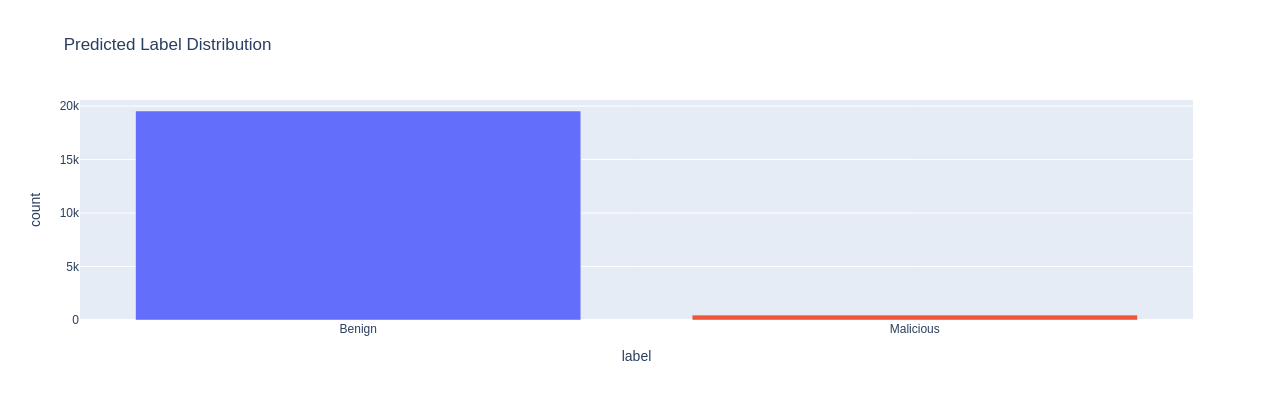

In [3]:
import plotly.express as px
if df.empty:
    print('No data to visualize')
else:
    # Prefer 'predicted_label' if available, otherwise fall back to numeric 'prediction'
    if 'predicted_label' in df.columns:
        col = 'predicted_label'
    elif 'prediction' in df.columns:
        # map numeric predictions to labels for display
        df['predicted_label'] = df['prediction'].apply(lambda x: 'Benign' if x == 0.0 else ('Malicious' if x == 1.0 else str(x)))
        col = 'predicted_label'
    else:
        print('No prediction column found')
        col = None
    if col is not None:
        counts = df[col].value_counts().rename_axis('label').reset_index(name='count')
        fig = px.bar(counts, x='label', y='count', color='label', title='Predicted Label Distribution')
        fig.update_layout(showlegend=False, height=400)
        fig.show()

## Time-series: predictions per minute
Aggregate predictions over a 1-minute interval to see throughput and spikes.

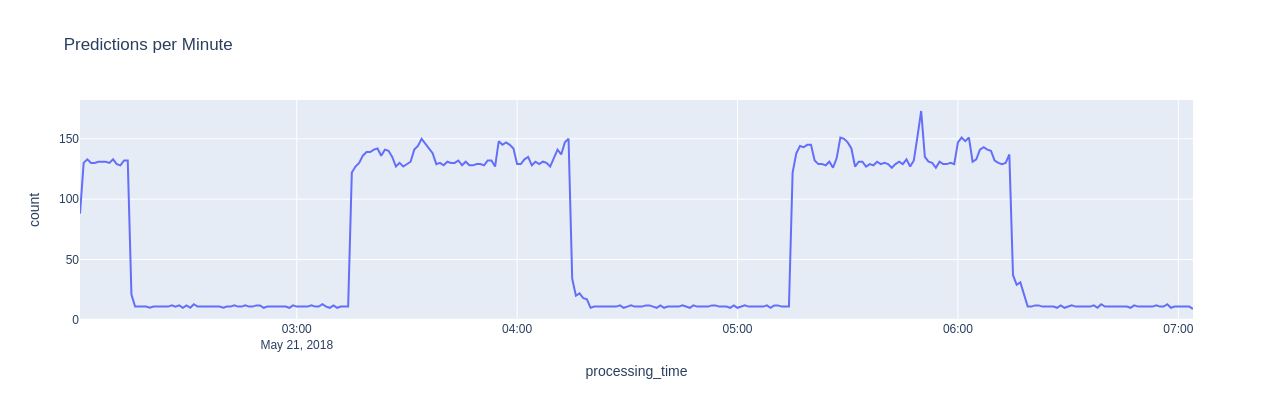

In [4]:
if df.empty or 'processing_time' not in df.columns:
    print('No time-series data available')
else:
    ts = df.set_index('processing_time')
    counts = ts.resample('1T').size().rename('count').to_frame()
    counts = counts.reset_index()
    fig = px.line(counts, x='processing_time', y='count', title='Predictions per Minute')
    fig.update_layout(height=400)
    fig.show()

## Real-time alert demo
A simple rule: if the malicious rate in the last 1 minute exceeds a threshold and there are enough events, print an alert and show recent malicious records.

In [5]:
from IPython.display import display
if df.empty or 'processing_time' not in df.columns:
    print('No recent records to evaluate alerts')
else:
    now = df['processing_time'].max()
    window = df[df['processing_time'] >= now - pd.Timedelta(minutes=1)]
    total = len(window)
    mal = (window['predicted_label'] == 'Malicious').sum() if 'predicted_label' in window.columns else 0
    rate = (mal/total) if total>0 else 0
    print(f'Last 1 minute: {mal}/{total} malicious ({rate:.2%})')
    TH = 0.20
    if total >= 10 and rate > TH:
        print('ALERT: High malicious rate')
        if mal>0:
            display(window[window['predicted_label']=='Malicious'].sort_values('processing_time').head(20))

Last 1 minute: 0/12 malicious (0.00%)


## Model evaluation
If the producer preserved the true `label` in the Kafka messages, we can compute classification metrics by comparing `label` with `predicted_label`.

In [6]:
if df.empty or 'label' not in df.columns or 'predicted_label' not in df.columns:
    print('True labels or predictions not available; skipping evaluation')
else:
    from sklearn.metrics import classification_report, confusion_matrix
    eval_df = df.dropna(subset=['label','predicted_label'])
    y_true = eval_df['label'].astype(str)
    y_pred = eval_df['predicted_label'].astype(str)
    print(classification_report(y_true, y_pred))
    cm = confusion_matrix(y_true, y_pred, labels=['Benign','Malicious'])
    cm_df = pd.DataFrame(cm, index=['Benign','Malicious'], columns=['Pred_Benign','Pred_Malicious'])
    display(cm_df)

True labels or predictions not available; skipping evaluation


## Export snapshot
Save a CSV for reporting and offline analysis.

In [7]:
out = os.path.abspath('reports')
os.makedirs(out, exist_ok=True)
csv_out = os.path.join(out, 'predictions_snapshot.csv')
if not df.empty:
    df.to_csv(csv_out, index=False)
    print('Wrote snapshot to', csv_out)
else:
    print('No data to export')

Wrote snapshot to /home/jovyan/work/artifacts/predictions_snapshot.csv
